In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import string
import joblib
import re

In [2]:
df = pd.read_csv('spam_Emails_data.csv')
df.head()

,label,text
0,Spam,viiiiiiagraaaa\nonly for the ones that want to...
1,Ham,got ice thought look az original message ice o...
2,Spam,yo ur wom an ne eds an escapenumber in ch ma n...
3,Spam,start increasing your odds of success & live s...
4,Ham,author jra date escapenumber escapenumber esca...


In [3]:
df['label'] = df['label'].apply(lambda x: 1 if x=='Spam' else 0)

In [4]:
df['label'].unique()

array([1, 0])

In [5]:
df = df.dropna()

In [6]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [7]:
def clean_text(text):
    text = str(text).lower()                               # Lowercase
    text = re.sub(r'\n', ' ', text)                        # Remove newlines
    text = re.sub(r'http\S+|www.\S+', '', text)            # Remove URLs
    text = re.sub(r'<.*?>', '', text)                      # Remove HTML tags
    text = re.sub(r'\d+', '', text)                        # Remove numbers
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()               # Remove extra whitespace
    return text

In [8]:
df['text'] = df['text'].apply(clean_text)

In [9]:
manual_stopwords = set("""
a about above after again against all am an and any are aren't as at be because been before being below between 
both but by can't cannot could couldn't did didn't do does doesn't doing don't down during each few for from further 
had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers herself him himself his how how's i 
i'd i'll i'm i've if in into is isn't it it's its itself let's me more most mustn't my myself no nor not of off on 
once only or other ought our ours ourselves out over own same shan't she she'd she'll she's should shouldn't so some 
such than that that's the their theirs them themselves then there there's these they they'd they'll they're they've 
this those through to too under until up very was wasn't we we'd we'll we're we've were weren't what what's when when's 
where where's which while who who's whom why why's with won't would wouldn't you you'd you'll you're you've your yours 
yourself yourselves
""".split())

In [10]:
def extract_features(text):
    words = text.lower().split()
    total_words = len(words)
    stopword_count = sum(1 for word in words if word in manual_stopwords)
    
    return pd.Series({
        'text_length': len(text),
        'word_count': total_words,
        'sentence_count': text.count('.') + text.count('!') + text.count('?'),
        'punctuation_count': sum([1 for char in text if char in '.,!?;:']),
        'uppercase_ratio': sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0,
        'unique_word_count': len(set(words)),
        'stopword_ratio': stopword_count / total_words if total_words > 0 else 0,
        'avg_word_len': np.mean([len(word) for word in words]) if words else 0,
    })


In [11]:
extra_features_df = df['text'].apply(extract_features)

In [12]:
df.dtypes

label     int64
text     object
dtype: object

In [13]:
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df['text'])

In [14]:
X_text.shape, extra_features_df.shape

((193850, 5000), (193850, 8))

In [15]:
from sklearn.preprocessing import StandardScaler

# Scale only the extra features
scaler = StandardScaler()
extra_features_scaled = scaler.fit_transform(extra_features_df)

In [16]:
X_all = np.hstack([X_text.toarray(), extra_features_scaled])
y = df['label']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, stratify=y, random_state=42)


In [18]:
import numpy as np
print("Unique labels in y:", np.unique(y))
print("Unique labels in y_train:", np.unique(y_train))


Unique labels in y: [0 1]
Unique labels in y_train: [0 1]


In [19]:
model = LogisticRegression(class_weight='balanced', max_iter=3000)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=3000)

In [20]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     20432
           1       0.96      0.98      0.97     18338

    accuracy                           0.97     38770
   macro avg       0.97      0.97      0.97     38770
weighted avg       0.97      0.97      0.97     38770



In [21]:
# from sklearn.model_selection import GridSearchCV

# params = {
#     'C': [0.1, 1, 10],
#     'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 1.5}, 'balanced']
# }
# grid = GridSearchCV(LogisticRegression(max_iter=3000), params, scoring='recall', cv=5)
# grid.fit(X_train, y_train)

# print(grid.best_params_)

In [22]:
from sklearn.metrics import classification_report

y_probs = model.predict_proba(X_test)[:, 1]  # Get probability for class 1
threshold = 0.3  # Try 0.4, 0.35, etc.
y_pred_thresh = (y_probs >= threshold).astype(int)

print(classification_report(y_test, y_pred_thresh))


              precision    recall  f1-score   support

           0       0.99      0.94      0.97     20432
           1       0.94      0.99      0.96     18338

    accuracy                           0.96     38770
   macro avg       0.96      0.97      0.96     38770
weighted avg       0.97      0.96      0.96     38770



Text(95.72222222222221, 0.5, 'Truth')

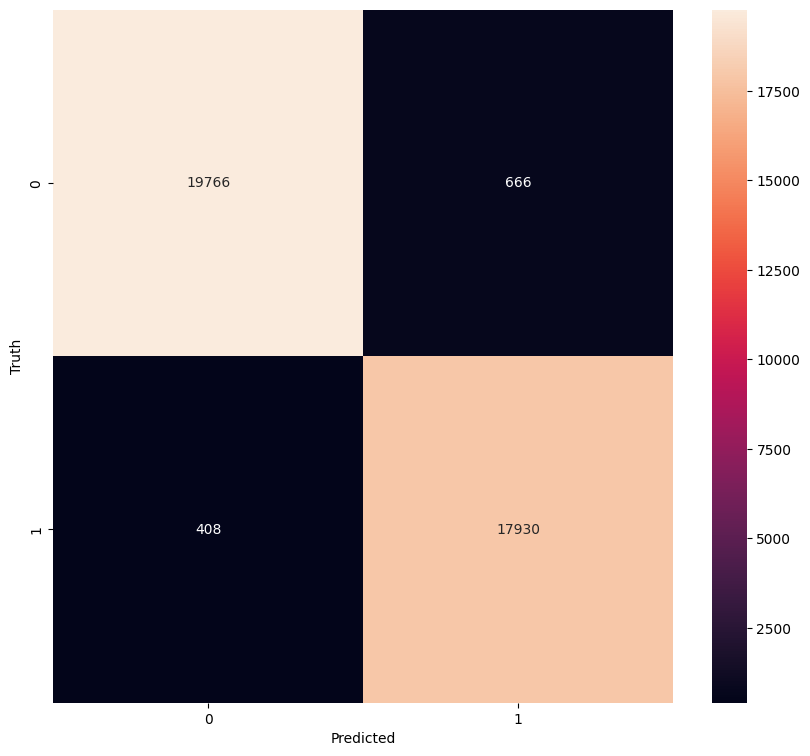

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
labels=[ 0, 1]

plt.figure(figsize=(10,9))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [24]:
df3=pd.DataFrame(X_text)
df3

,0
0,<Compressed Sparse Row sparse matrix of dtype ...
1,<Compressed Sparse Row sparse matrix of dtype ...
2,<Compressed Sparse Row sparse matrix of dtype ...
3,<Compressed Sparse Row sparse matrix of dtype ...
4,<Compressed Sparse Row sparse matrix of dtype ...
...,...
193845,<Compressed Sparse Row sparse matrix of dtype ...
193846,<Compressed Sparse Row sparse matrix of dtype ...
193847,<Compressed Sparse Row sparse matrix of dtype ...
193848,<Compressed Sparse Row sparse matrix of dtype ...


In [25]:
# In your training notebook, after train/test split:
background_sample_size = min(100, len(X_train))
background_indices = np.random.choice(len(X_train), background_sample_size, replace=False)
background_data = X_train[background_indices]
np.save('shap_background_data.npy', background_data)

In [26]:
joblib.dump(model, 'spam_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(extra_features_df.columns.tolist(), 'extra_feature_names.pkl')

['extra_feature_names.pkl']

In [27]:
# Save the scaler for use in prediction
joblib.dump(scaler, 'extra_features_scaler.pkl')
print("Scaler saved successfully!")

Scaler saved successfully!


In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
models = [
    (
        "Logistic Regression", 
        {"C": 1, "solver": 'liblinear'},
        LogisticRegression(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "Random Forest", 
        {"n_estimators": 30, "max_depth": 3},
        RandomForestClassifier(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    # (
    #     "XGBClassifier",
    #     {"use_label_encoder": False, "eval_metric": 'logloss'},
    #     XGBClassifier(), 
    #     (X_train, y_train),
    #     (X_test, y_test)
    # ),
    # (
    #     "XGBClassifier With SMOTE",
    #     {"use_label_encoder": False, "eval_metric": 'logloss'},
    #     XGBClassifier(), 
    #     (X_train_res, y_train_res),
    #     (X_test, y_test)
    # )
]

In [32]:
reports = []

for model_name, params, model, train_set, test_set in models:
    X_train = train_set[0]
    y_train = train_set[1]
    X_test = test_set[0]
    y_test = test_set[1]
    
    model.set_params(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

In [33]:
import mlflow
import mlflow.sklearn

In [35]:
import dagshub
dagshub.init(repo_owner='sinanshamsudheen', repo_name='TLflow', mlflow=True)

Initialized MLflow to track repo "sinanshamsudheen/TLflow"

Repository sinanshamsudheen/TLflow initialized!

In [36]:
# Ideally you will not require following 4 lines if you have started fresh and do not have any previous dagshub credentials on your computer
import os
# os.environ['MLFLOW_TRACKING_USERNAME'] = 'your user name' # 'learnpythonlanguage'
# os.environ['MLFLOW_TRACKING_PASSWORD'] = 'your password' # 
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/sinanshamsudheen/TFflow.mlflow' # https://dagshub.com/learnpythonlanguage/mlflow_dagshub_demo.mlflow

# Initialize MLflow
mlflow.set_experiment("Email Spam Detection")
# mlflow.set_tracking_uri("http://localhost:5000")

for i, element in enumerate(models):
    model_name = element[0]
    params = element[1]
    model = element[2]
    report = reports[i]
    
    with mlflow.start_run(run_name=model_name):        
        mlflow.log_params(params)
        mlflow.log_metrics({
            'accuracy': report['accuracy'],
            'recall_class_1': report['1']['recall'],
            'recall_class_0': report['0']['recall'],
            'precision_class_1': report['1']['precision'],
            'precision_class_0': report['0']['precision'],
            'f1_score_macro': report['macro avg']['f1-score'],
            'precision_macro': report['macro avg']['precision']
        })  
        
        if "XGB" in model_name:
            mlflow.xgboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")  

MlflowException: API request to endpoint /api/2.0/mlflow/experiments/get-by-name failed with error code 404 != 200. Response body: ''